# Generate AWG file for Advantest R3681 - Two Tone Signal

## Input Parameters

In [27]:
sample_rate      = 12500000
freq1            = 700
freq2            = 1900
num_periods      = 1
comment          = "Two tone - 700Hz + 1900Hz, sampling rate: 12.5MHz"
file_name        = "2tone-700hz+1900hz.awv"

## Generate the IQ Signal Data

In [54]:
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from math import lcm
from scipy.signal import hilbert
from scipy.fft import fft, fftfreq

#
# Generate floating point waveform data
#

# Calulate the period 
period_duration = lcm(freq1, freq2) / (freq1 * freq2)
period_samples = int(sample_rate*period_duration)
   
num_samples = period_samples * num_periods

# The sig gen needs at least 1024 samples per channel
if num_samples < 1024:
    mult = 1 + int(1024/num_samples)
    num_samples = num_samples * mult
    num_periods = num_periods * mult
    
duration_seconds = period_duration * num_periods

t = np.linspace(0, duration_seconds, num_samples, False)

signal = (np.cos(2*np.pi * freq1 * t) + np.cos(2*np.pi * freq2 * t)) / 2
iq_complex = hilbert(signal)

i_float = iq_complex.real
q_float = iq_complex.imag

## Samples Plot

Number of full periods: 1
Number of samples: 125000
Duration: 0.01 sec


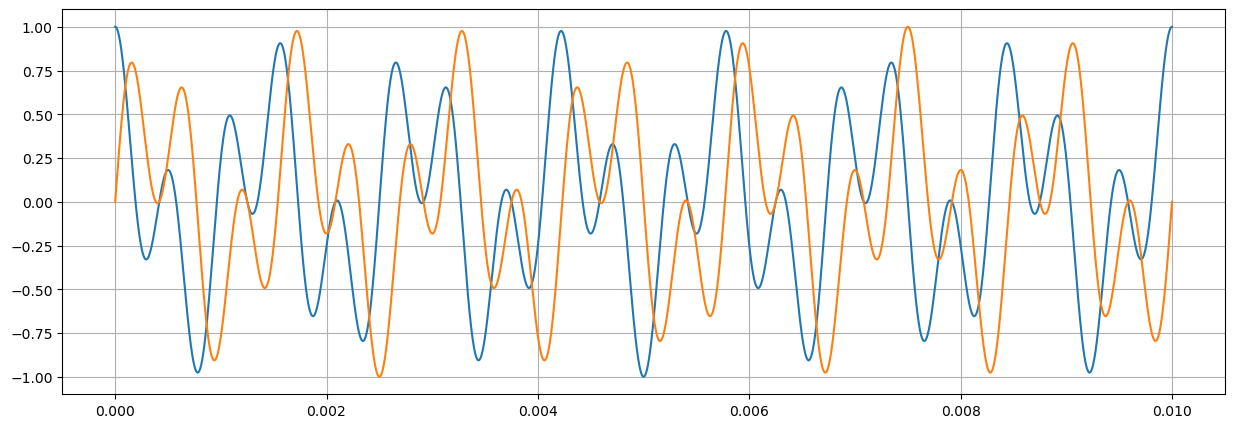

In [43]:
print("Number of full periods:", num_periods)
print("Number of samples:",len(i_float))
print("Duration:", duration_seconds, "sec")

plt.figure(figsize=(15,5))
plt.plot(t, i_float)
plt.plot(t, q_float)
plt.grid()
plt.show()

## Spectrum Plot

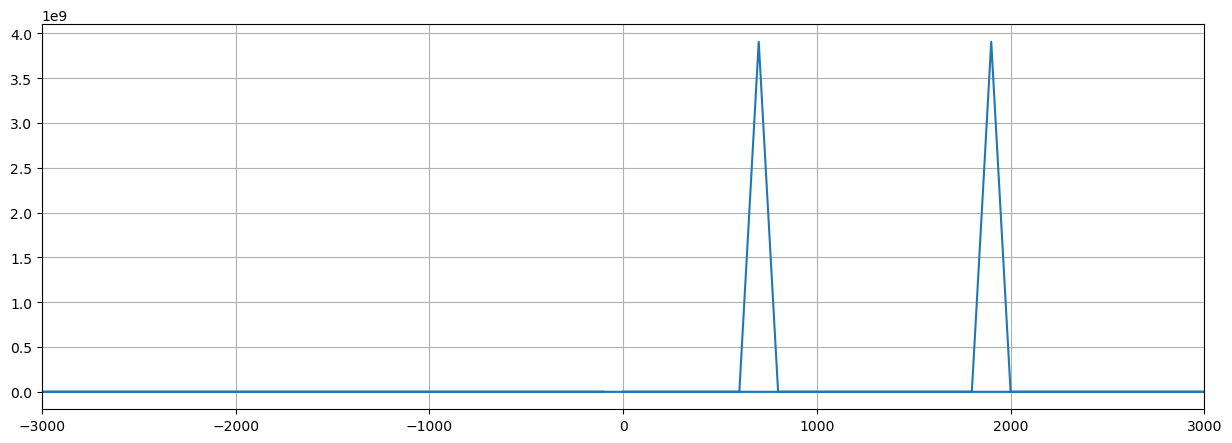

In [44]:
signal_spectrum = fft(iq_complex)
freqs = fftfreq(num_samples, d=1/sample_rate)

plt.figure(figsize=(15,5))
plt.plot(freqs, np.abs(signal_spectrum)**2)
plt.xlim(-3000, 3000)
plt.grid()
plt.show()

## Write to File

In [53]:
#
# Normalize to 32 bit unsigned int
#

i_int = np.uint32(float(0x2000) + float(0x1fff) * i_float)
q_int = np.uint32(float(0x2000) + float(0x1fff) * q_float)

#
# Write file
#

date_str = datetime.now().strftime("%Y/%m/%d;%H:%M:%S")

with open(file_name, "wb") as file:
    file.write(b"{COMMENT:")
    file.write(bytes(comment, 'ASCII'))
    file.write(b"}\n")
    file.write(b"{DATE:")
    file.write(bytes(date_str, 'ASCII'))
    file.write(b"}\n")
    file.write(b"{SAMPLINGFREQ:")
    file.write(bytes("%.5E" % sample_rate, "ASCII"))
    file.write(b"}\n")
    file.write(bytes("{WAVEDATA:%d;" % (4*len(i_int)*2), 'ASCII'))
    for i in range(len(i_int)):
        file.write(i_int[i])
        file.write(q_int[i])
    file.write(b"}")